In [2]:
import json
import networkx as nx
from typing import Dict, Any, List
import matplotlib.pyplot as plt
import spacy
from spacy.matcher import Matcher

class SchemaToGraphConverter:
    def __init__(self):
        self.graph = nx.Graph()
        self.nlp = spacy.load("en_core_web_sm")

    def visualize(self):
            pos = nx.spring_layout(self.graph, k=0.5, iterations=50)
            
            plt.figure(figsize=(12, 8))
            
            # Color mapping
            color_map = {
                'table': '#FF9999',  # Light Red
                'column': '#66B2FF',  # Light Blue
                'data_type': '#99FF99',  # Light Green
                'constraint': '#FFFF99',  # Light Yellow
                'synonym': '#FFB366',  # Light Orange
                'semantic': '#FF99FF'  # Light Purple
            }
            
            # Draw nodes
            for node_type in color_map:
                node_list = [node for node, data in self.graph.nodes(data=True) if data['type'] == node_type]
                nx.draw_networkx_nodes(self.graph, pos, nodelist=node_list, node_color=color_map[node_type], node_size=3000, alpha=0.8)

            # Draw edges
            nx.draw_networkx_edges(self.graph, pos, alpha=0.5)
            
            # Add labels
            labels = {node: node for node in self.graph.nodes()}
            nx.draw_networkx_labels(self.graph, pos, labels, font_size=8)
            
            # Add a legend
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=node_type.capitalize(),
                            markerfacecolor=color, markersize=10)
                            for node_type, color in color_map.items()]
            plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

            plt.title("Database Schema Graph Visualization")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

    def load_schema(self, schema_json: str):
        schema = json.loads(schema_json)
        self._process_schema(schema)

    def _process_schema(self, schema: Dict[str, Any]):
        for table_name, table_info in schema.items():
            self._add_table_node(table_name, table_info)
            self._process_columns(table_name, table_info['columns'])
            self._process_relationships(table_name, table_info.get('relationships', []))

    def _add_table_node(self, table_name: str, table_info: Dict[str, Any]):
        self.graph.add_node(table_name, type='table', description=table_info.get('description', ''))

    def _process_columns(self, table_name: str, columns: Dict[str, Any]):
        for column_name, column_info in columns.items():
            column_node = f"{table_name}.{column_name}"
            self.graph.add_node(column_node, type='column', 
                                nullable=column_info.get('nullable', True),
                                default=column_info.get('default', None))
            self.graph.add_edge(table_name, column_node, type='has_column')

            # Add data type node
            data_type = column_info['data_type']
            self.graph.add_node(data_type, type='data_type')
            self.graph.add_edge(column_node, data_type, type='has_data_type')

            # Add constraints
            for constraint in column_info.get('constraints', []):
                self.graph.add_node(constraint, type='constraint')
                self.graph.add_edge(column_node, constraint, type='has_constraint')

            # Add synonyms
            for synonym in column_info.get('synonyms', []):
                self.graph.add_node(synonym, type='synonym')
                self.graph.add_edge(column_node, synonym, type='has_synonym')

    def _process_relationships(self, table_name: str, relationships: list):
        for relationship in relationships:
            related_table = relationship['related_table']
            self.graph.add_edge(table_name, related_table, type='related_to',
                                relationship_type=relationship['type'])

    def add_semantic_nodes(self, semantic_info: Dict[str, list]):
        for concept, related_elements in semantic_info.items():
            self.graph.add_node(concept, type='semantic')
            for element in related_elements:
                if self.graph.has_node(element):
                    self.graph.add_edge(concept, element, type='related_to')

    def get_related_tables(self, concept: str) -> list:
        related_nodes = nx.neighbors(self.graph, concept)
        return [node for node in related_nodes if self.graph.nodes[node]['type'] == 'table']

    def find_join_path(self, table1: str, table2: str) -> list:
        try:
            path = nx.shortest_path(self.graph, table1, table2)
            return [node for node in path if self.graph.nodes[node]['type'] == 'table']
        except nx.NetworkXNoPath:
            return []

    def get_column_info(self, table_name: str) -> Dict[str, Any]:
        columns = {}
        for node in nx.neighbors(self.graph, table_name):
            if self.graph.nodes[node]['type'] == 'column':
                column_name = node.split('.')[1]
                columns[column_name] = self.graph.nodes[node]
        return columns



    def question_to_sql_elements(self, question: str) -> Dict[str, List[str]]:
        # Process the question with spaCy
        doc = self.nlp(question)
        
        # Extract relevant words (nouns and proper nouns)
        relevant_words = [token.text.lower() for token in doc if token.pos_ in ['NOUN', 'PROPN']]
        
        # Find matching nodes in the graph
        matches = {
            'tables': [],
            'columns': [],
            'concepts': []
        }
        
        for word in relevant_words:
            for node in self.graph.nodes():
                node_type = self.graph.nodes[node]['type']
                if word in node.lower():
                    if node_type == 'table':
                        matches['tables'].append(node)
                    elif node_type == 'column':
                        matches['columns'].append(node)
                    elif node_type in ['synonym', 'semantic']:
                        matches['concepts'].append(node)
        
        # Remove duplicates
        for key in matches:
            matches[key] = list(set(matches[key]))
        
        return matches

    def get_related_columns(self, table: str) -> List[str]:
        return [node for node in nx.neighbors(self.graph, table) 
                if self.graph.nodes[node]['type'] == 'column']

    def process_question(self, question: str) -> Dict[str, Any]:
        # Get initial matches
        matches = self.question_to_sql_elements(question)
        
        # Expand matches to include related elements
        expanded_matches = {
            'tables': set(matches['tables']),
            'columns': set(matches['columns']),
            'concepts': set(matches['concepts'])
        }
        
        # Add tables related to matched concepts
        for concept in matches['concepts']:
            expanded_matches['tables'].update(self.get_related_tables(concept))
        
        # Add columns for all matched tables
        for table in expanded_matches['tables']:
            expanded_matches['columns'].update(self.get_related_columns(table))
        
        # Convert sets back to lists
        result = {k: list(v) for k, v in expanded_matches.items()}
        
        # Add potential joins
        result['potential_joins'] = self.find_potential_joins(result['tables'])
        
        return result

    def find_potential_joins(self, tables: List[str]) -> List[tuple]:
        joins = []
        for i in range(len(tables)):
            for j in range(i+1, len(tables)):
                path = self.find_join_path(tables[i], tables[j])
                if path:
                    joins.append((tables[i], tables[j], path))
        return joins


In [3]:

class EnhancedSchemaToGraphConverter(SchemaToGraphConverter):
    def __init__(self):
        super().__init__()
        self.nlp = spacy.load("en_core_web_sm")
        self.matcher = Matcher(self.nlp.vocab)
        
        # Define patterns for common SQL operations
        self.matcher.add("AGGREGATION", [[{"LOWER": {"IN": ["average", "avg", "sum", "count", "max", "min"]}}]])
        self.matcher.add("GROUPING", [[{"LOWER": "group"}, {"LOWER": "by"}]])
        self.matcher.add("ORDERING", [[{"LOWER": {"IN": ["order", "sort"]}}, {"LOWER": "by"}]])
        self.matcher.add("LIMIT", [[{"LOWER": {"IN": ["top", "bottom"]}}, {"POS": "NUM"}]])
        self.matcher.add("TIME_RANGE", [[{"LOWER": {"IN": ["last", "past"]}}, {"POS": "NUM"}, {"LOWER": {"IN": ["day", "week", "month", "year"]}}]])

    def advanced_question_processing(self, question: str) -> Dict[str, Any]:
        doc = self.nlp(question)
        
        # Extract entities and operations
        entities = [ent.text for ent in doc.ents]
        operations = []
        for match_id, start, end in self.matcher(doc):
            operations.append(doc[start:end].text)
        
        # Get relevant tables and columns
        basic_elements = self.question_to_sql_elements(question)
        
        # Identify potential joins and related tables
        all_tables = set(basic_elements['tables'])
        for table in basic_elements['tables']:
            all_tables.update(self.get_related_tables(table))
        
        potential_joins = self.find_potential_joins(list(all_tables))
        
        return {
            "entities": entities,
            "operations": operations,
            "tables": list(all_tables),
            "columns": basic_elements['columns'],
            "concepts": basic_elements['concepts'],
            "potential_joins": potential_joins
        }

    def get_related_tables(self, table: str) -> List[str]:
        related = []
        for node in nx.neighbors(self.graph, table):
            if self.graph.nodes[node]['type'] == 'table':
                related.append(node)
        return related

In [4]:
#  Example usage
# converter = SchemaToGraphConverter()
# Example usage
converter = EnhancedSchemaToGraphConverter()

In [5]:
# Example schema
# schema_json = '''
# {
#     "users": {
#         "description": "Store user information",
#         "columns": {
#             "id": {
#                 "data_type": "integer",
#                 "constraints": ["primary_key"],
#                 "synonyms": ["user_id", "user_identifier"]
#             },
#             "username": {
#                 "data_type": "varchar",
#                 "constraints": ["unique"],
#                 "synonyms": ["user_name", "login"]
#             },
#             "email": {
#                 "data_type": "varchar",
#                 "constraints": ["unique"],
#                 "synonyms": ["user_email", "email_address"]
#             }
#         },
#         "relationships": [
#             {"related_table": "orders", "type": "has_many"}
#         ]
#     },
#     "orders": {
#         "description": "Store order information",
#         "columns": {
#             "id": {
#                 "data_type": "integer",
#                 "constraints": ["primary_key"],
#                 "synonyms": ["order_id", "order_number"]
#             },
#             "user_id": {
#                 "data_type": "integer",
#                 "constraints": ["foreign_key"],
#                 "synonyms": ["customer_id"]
#             },
#             "total_amount": {
#                 "data_type": "decimal",
#                 "synonyms": ["order_total", "amount"]
#             }
#         },
#         "relationships": [
#             {"related_table": "users", "type": "belongs_to"}
#         ]
#     }
# }
# '''


#  Load schema (using an extended version of the previous schema)
schema_json = '''
{
    "users": {
        "description": "Store user information",
        "columns": {
            "id": {"data_type": "integer", "constraints": ["primary_key"]},
            "username": {"data_type": "varchar", "constraints": ["unique"]},
            "email": {"data_type": "varchar", "constraints": ["unique"]},
            "age": {"data_type": "integer"},
            "registration_date": {"data_type": "date"}
        },
        "relationships": [
            {"related_table": "orders", "type": "has_many"}
        ]
    },
    "orders": {
        "description": "Store order information",
        "columns": {
            "id": {"data_type": "integer", "constraints": ["primary_key"]},
            "user_id": {"data_type": "integer", "constraints": ["foreign_key"]},
            "total_amount": {"data_type": "decimal"},
            "date": {"data_type": "date"}
        },
        "relationships": [
            {"related_table": "users", "type": "belongs_to"},
            {"related_table": "order_items", "type": "has_many"}
        ]
    },
    "products": {
        "description": "Store product information",
        "columns": {
            "id": {"data_type": "integer", "constraints": ["primary_key"]},
            "name": {"data_type": "varchar"},
            "price": {"data_type": "decimal"},
            "category": {"data_type": "varchar"}
        },
        "relationships": [
            {"related_table": "order_items", "type": "has_many"}
        ]
    },
    "order_items": {
        "description": "Store items within each order",
        "columns": {
            "id": {"data_type": "integer", "constraints": ["primary_key"]},
            "order_id": {"data_type": "integer", "constraints": ["foreign_key"]},
            "product_id": {"data_type": "integer", "constraints": ["foreign_key"]},
            "quantity": {"data_type": "integer"}
        },
        "relationships": [
            {"related_table": "orders", "type": "belongs_to"},
            {"related_table": "products", "type": "belongs_to"}
        ]
    }
}
'''


In [6]:

converter.load_schema(schema_json)



In [7]:
# Add semantic nodes
# semantic_info = {
#     "customer": ["users", "users.username", "users.email"],
#     "purchase": ["orders", "orders.total_amount"]
# }

# Add semantic nodes
semantic_info = {
    "customer": ["users", "users.username", "users.email"],
    "purchase": ["orders", "orders.total_amount"],
    "product_info": ["products", "products.name", "products.price"],
    "order_details": ["order_items", "order_items.quantity"]
}
converter.add_semantic_nodes(semantic_info)



In [8]:
# Example queries
print("Related tables to 'customer':", converter.get_related_tables("customer"))
print("Join path between 'users' and 'orders':", converter.find_join_path("users", "orders"))
print("Column info for 'users':", converter.get_column_info("users"))



Related tables to 'customer': ['users']
Join path between 'users' and 'orders': ['users', 'orders']
Column info for 'users': {'id': {'type': 'column', 'nullable': True, 'default': None}, 'username': {'type': 'column', 'nullable': True, 'default': None}, 'email': {'type': 'column', 'nullable': True, 'default': None}, 'age': {'type': 'column', 'nullable': True, 'default': None}, 'registration_date': {'type': 'column', 'nullable': True, 'default': None}}


In [9]:
# Test the question answering pipeline
question = "What is the total amount of orders for each customer?"
result = converter.process_question(question)
print("Relevant elements for the question:")
print(json.dumps(result, indent=2))

Relevant elements for the question:
{
  "tables": [
    "orders",
    "users"
  ],
  "columns": [
    "orders.user_id",
    "orders.total_amount",
    "orders.id",
    "users.username",
    "users.age",
    "users.id",
    "users.registration_date",
    "users.email",
    "orders.date"
  ],
  "concepts": [
    "customer"
  ],
  "potential_joins": [
    [
      "orders",
      "users",
      [
        "orders",
        "users"
      ]
    ]
  ]
}


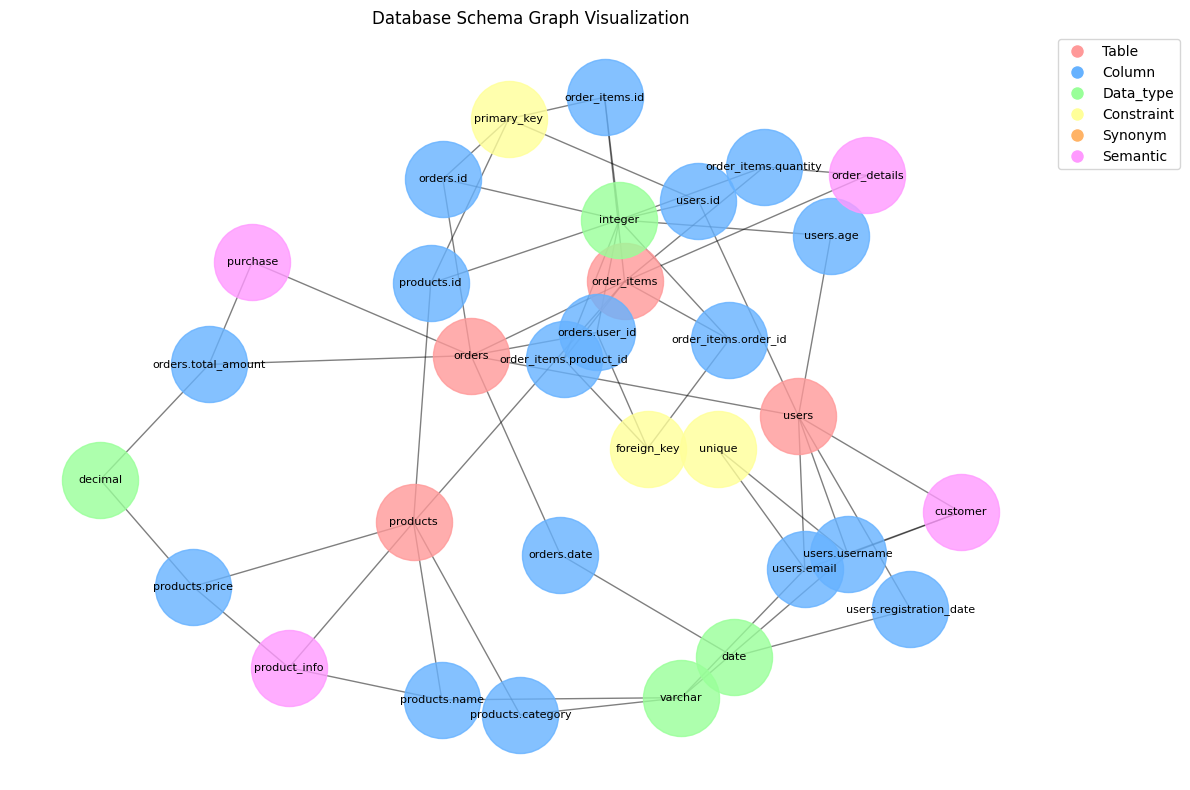

In [10]:
# Visualize the graph
converter.visualize()

In [11]:
##Question1: "What is the average order value for customers who have made more than 5 purchases?"
# Relevant tables and columns:

# users (id)
# orders (id, user_id, total_amount)

# Test the advanced question processing
complex_question = "What is the average order value for customers who have made more than 5 purchases?"
result = converter.advanced_question_processing(complex_question)
print("Advanced processing result for the question:")
print(json.dumps(result, indent=2))

# Visualize the graph
# converter.visualize()

Advanced processing result for the question:
{
  "entities": [
    "more than 5"
  ],
  "operations": [
    "average"
  ],
  "tables": [
    "products",
    "orders",
    "users",
    "order_items"
  ],
  "columns": [
    "order_items.quantity",
    "orders.user_id",
    "orders.id",
    "orders.total_amount",
    "order_items.order_id",
    "order_items.product_id",
    "order_items.id",
    "orders.date"
  ],
  "concepts": [
    "order_details"
  ],
  "potential_joins": [
    [
      "products",
      "orders",
      [
        "products",
        "order_items",
        "orders"
      ]
    ],
    [
      "products",
      "users",
      [
        "products",
        "order_items",
        "orders",
        "users"
      ]
    ],
    [
      "products",
      "order_items",
      [
        "products",
        "order_items"
      ]
    ],
    [
      "orders",
      "users",
      [
        "orders",
        "users"
      ]
    ],
    [
      "orders",
      "order_items",
      [
    

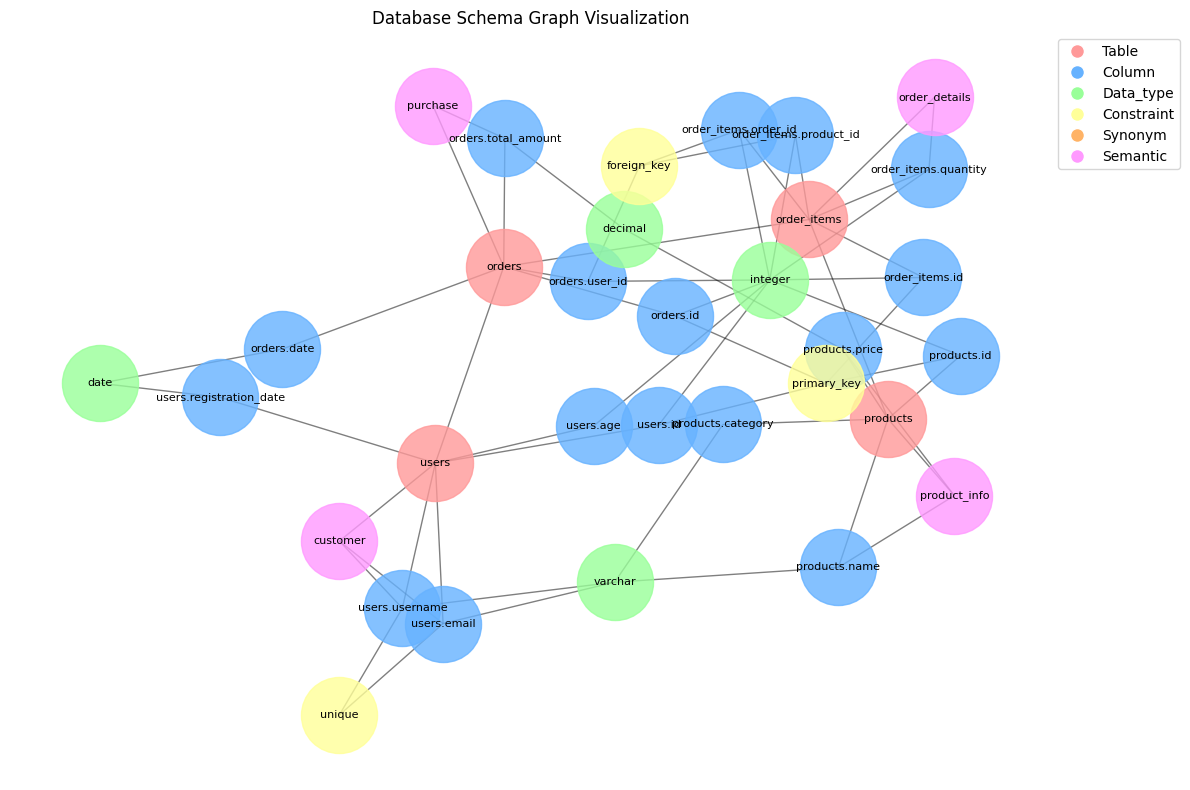

In [12]:
# Visualize the graph
converter.visualize()

### Question2

In [13]:
# Question: "Who are the top 5 customers by total spending in the last month?"
# Relevant tables and columns:

# users (id, username)
# orders (user_id, total_amount, date)
# Note: We'd need to add a 'date' column to the orders table.

complex_question = "Who are the top 5 customers by total spending in the last month?"
result = converter.advanced_question_processing(complex_question)
print("Advanced processing result for the question:")
print(json.dumps(result, indent=2))


Advanced processing result for the question:
{
  "entities": [
    "5",
    "the last month"
  ],
  "operations": [
    "top 5"
  ],
  "tables": [],
  "columns": [],
  "concepts": [],
  "potential_joins": []
}


### Question3

In [14]:
# Question: "What is the most popular product category among customers aged 25-35?"
# Relevant tables and columns:

# users (id, age)
# orders (id, user_id)
# order_items (order_id, product_id)
# products (id, category)
# Note: We'd need to add an 'age' column to the users table.


# Test the advanced question processing
complex_question = "What is the most popular product category among customers aged 25-35?"
result = converter.advanced_question_processing(complex_question)
print("Advanced processing result for the question:")
print(json.dumps(result, indent=2))

Advanced processing result for the question:
{
  "entities": [
    "25-35"
  ],
  "operations": [],
  "tables": [
    "products",
    "order_items"
  ],
  "columns": [
    "products.category",
    "products.price",
    "products.id",
    "products.name",
    "order_items.product_id"
  ],
  "concepts": [
    "product_info"
  ],
  "potential_joins": [
    [
      "products",
      "order_items",
      [
        "products",
        "order_items"
      ]
    ]
  ]
}


### Question 5

In [15]:
# Question: "What is the average number of items per order for each product category?"
# Relevant tables and columns:

# orders (id)
# order_items (order_id, product_id, quantity)
# products (id, category)

# Test the advanced question processing
complex_question = "What is the average number of items per order for each product category?"
result = converter.advanced_question_processing(complex_question)
print("Advanced processing result for the question:")
print(json.dumps(result, indent=2))

Advanced processing result for the question:
{
  "entities": [],
  "operations": [
    "average"
  ],
  "tables": [
    "products",
    "orders",
    "users",
    "order_items"
  ],
  "columns": [
    "order_items.quantity",
    "products.category",
    "orders.user_id",
    "orders.id",
    "orders.total_amount",
    "order_items.order_id",
    "products.price",
    "products.id",
    "products.name",
    "order_items.product_id",
    "order_items.id",
    "orders.date"
  ],
  "concepts": [
    "order_details",
    "product_info"
  ],
  "potential_joins": [
    [
      "products",
      "orders",
      [
        "products",
        "order_items",
        "orders"
      ]
    ],
    [
      "products",
      "users",
      [
        "products",
        "order_items",
        "orders",
        "users"
      ]
    ],
    [
      "products",
      "order_items",
      [
        "products",
        "order_items"
      ]
    ],
    [
      "orders",
      "users",
      [
        "orders",


### Question 6


In [16]:
# Question: "Who are the top 3 customers in each product category by total spending?"
# Relevant tables and columns:

# users (id, username)
# orders (id, user_id)
# order_items (order_id, product_id, quantity)
# products (id, category, price)

# Test the advanced question processing
complex_question = "Who are the top 3 customers in each product category by total spending?"
result = converter.advanced_question_processing(complex_question)
print("Advanced processing result for the question:")
print(json.dumps(result, indent=2))


Advanced processing result for the question:
{
  "entities": [
    "3"
  ],
  "operations": [
    "top 3"
  ],
  "tables": [
    "products",
    "order_items"
  ],
  "columns": [
    "products.category",
    "products.price",
    "products.id",
    "products.name",
    "order_items.product_id"
  ],
  "concepts": [
    "product_info"
  ],
  "potential_joins": [
    [
      "products",
      "order_items",
      [
        "products",
        "order_items"
      ]
    ]
  ]
}


Question 7

In [17]:
# Question: "What is the month-over-month growth rate in total sales for each product category?"
# Relevant tables and columns:

# orders (id, date, total_amount)
# order_items (order_id, product_id)
# products (id, category)

# Test the advanced question processing
complex_question = "What is the month-over-month growth rate in total sales for each product category?"
result = converter.advanced_question_processing(complex_question)
print("Advanced processing result for the question:")
print(json.dumps(result, indent=2))

Advanced processing result for the question:
{
  "entities": [],
  "operations": [],
  "tables": [
    "products",
    "order_items"
  ],
  "columns": [
    "products.category",
    "products.price",
    "products.id",
    "products.name",
    "order_items.product_id"
  ],
  "concepts": [
    "product_info"
  ],
  "potential_joins": [
    [
      "products",
      "order_items",
      [
        "products",
        "order_items"
      ]
    ]
  ]
}


Question 8

In [18]:
# Question: "Which products are often bought together?"
# Relevant tables and columns:

# orders (id)
# order_items (order_id, product_id)
# products (id, name)

# Test the advanced question processing
complex_question = "Which products are often bought together?"
result = converter.advanced_question_processing(complex_question)
print("Advanced processing result for the question:")
print(json.dumps(result, indent=2))


Advanced processing result for the question:
{
  "entities": [],
  "operations": [],
  "tables": [
    "products",
    "order_items"
  ],
  "columns": [
    "products.id",
    "products.name",
    "products.category",
    "products.price"
  ],
  "concepts": [],
  "potential_joins": [
    [
      "products",
      "order_items",
      [
        "products",
        "order_items"
      ]
    ]
  ]
}


Question 9

In [19]:
# Question: "Which customers have purchased all products in a specific category?"
# Relevant tables and columns:

# users (id, username)
# orders (id, user_id)
# order_items (order_id, product_id)
# products (id, category)

# Test the advanced question processing
complex_question = "Which customers have purchased all products in a specific category?"
result = converter.advanced_question_processing(complex_question)
print("Advanced processing result for the question:")
print(json.dumps(result, indent=2))

Advanced processing result for the question:
{
  "entities": [],
  "operations": [],
  "tables": [
    "products",
    "order_items"
  ],
  "columns": [
    "products.id",
    "products.name",
    "products.category",
    "products.price"
  ],
  "concepts": [],
  "potential_joins": [
    [
      "products",
      "order_items",
      [
        "products",
        "order_items"
      ]
    ]
  ]
}
